# 1: IMPORTING LIBRARIES AND DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from PIL import Image 
  

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [2]:
data = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [3]:
data.head(10)

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [4]:
import pandas as pd 
predCombined = pd.read_csv('../input/preds-combined-update/combined_preds.csv')
predCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 38 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   /kaggle/input/resnet-no-1/resnet101                               590 non-null    int64
 1   /kaggle/input/resnet-no-1/resnet50                                590 non-null    int64
 2   /kaggle/input/resnet-no-1/resnet50_2                              590 non-null    int64
 3   /kaggle/input/resnet-no-1-e46ccc/MobileNet                        590 non-null    int64
 4   /kaggle/input/resnet-no-1-e46ccc/MobileNet-2                      590 non-null    int64
 5   /kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3          590 non-null    int64
 6   /kaggle/input/fork-of-resnet-no-1-training-3/MobileNetV2          590 non-null    int64
 7   /kaggle/input/fork-of-resnet-no-1-training-3/ResNet15

In [5]:
data_map = []
for sub_dir_path in glob.glob("/kaggle/input/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

,patient_id,path
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...


In [7]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_13.tif 
Path to the Mask: /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_13_mask.tif


### creating final datset

In [8]:
# Final dataframe
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
1,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
2,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
4,TCGA_DU_7010_19860307,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
...,...,...,...,...
3924,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3925,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3926,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0
3927,TCGA_DU_7306_19930512,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,/kaggle/input/lgg-mri-segmentation/kaggle_3m/T...,0


# 2: DATA VISUALIZATION

In [9]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [10]:
import plotly.graph_objects as go  # using plotly to create interactive plots

fig = go.Figure([go.Bar(x=brain_df['mask'].value_counts().index, 
                        y=brain_df['mask'].value_counts(), 
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Mask Count Plot",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()

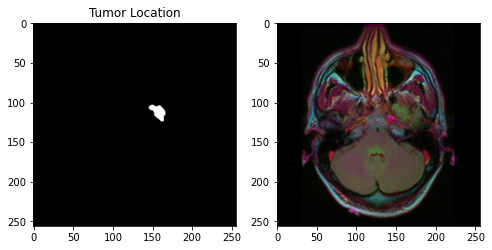

In [11]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [12]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

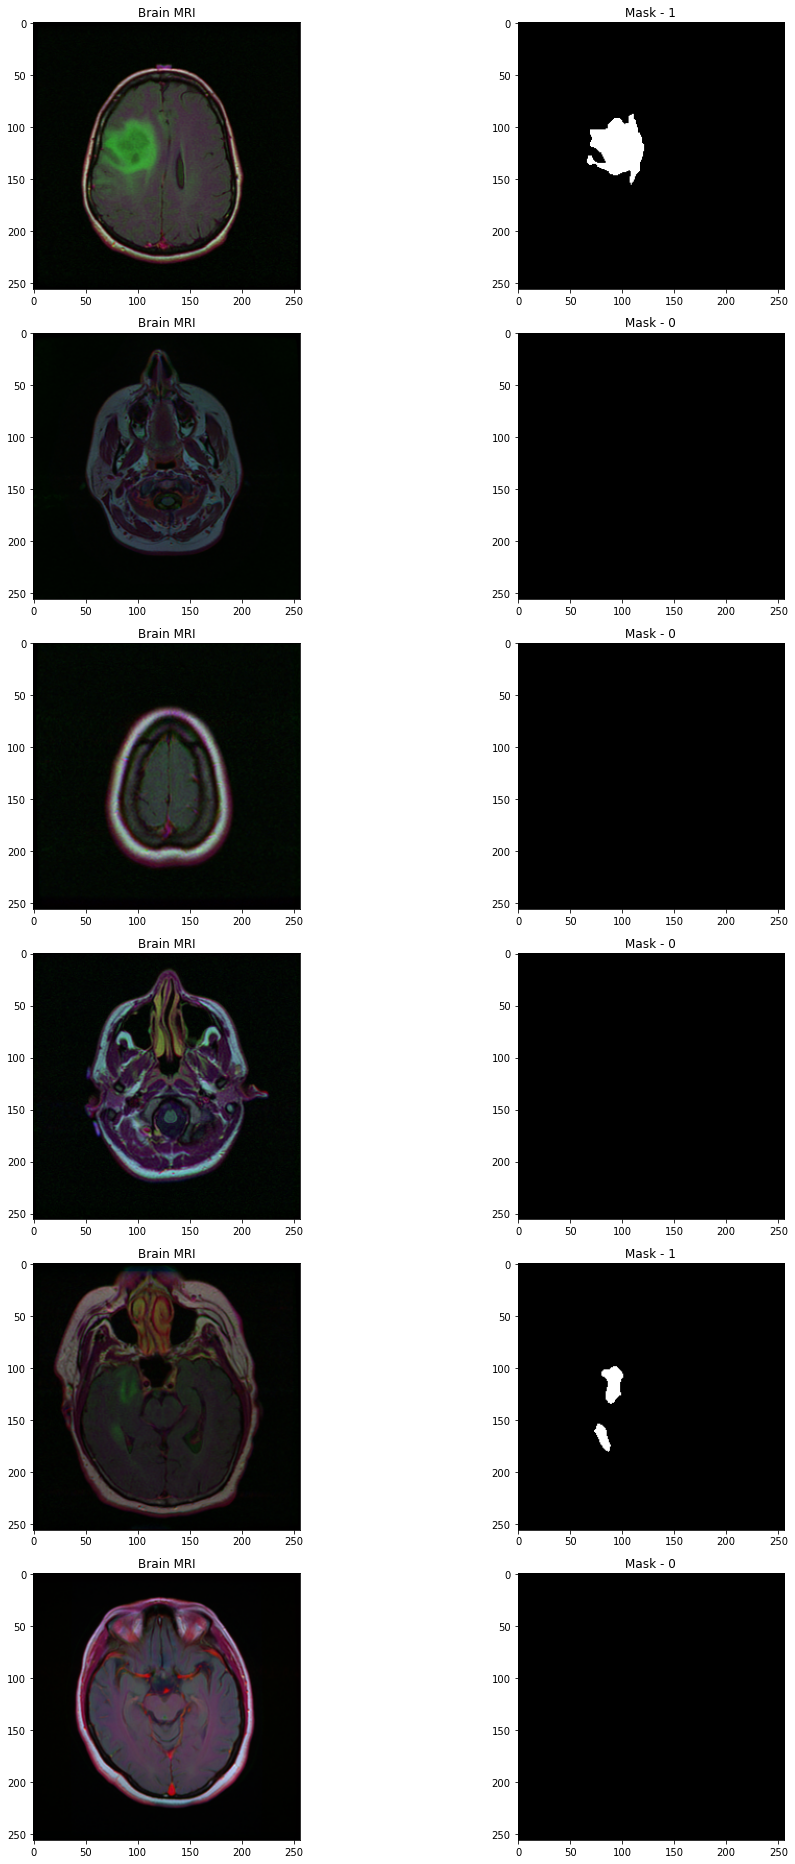

In [13]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately 

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI 
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

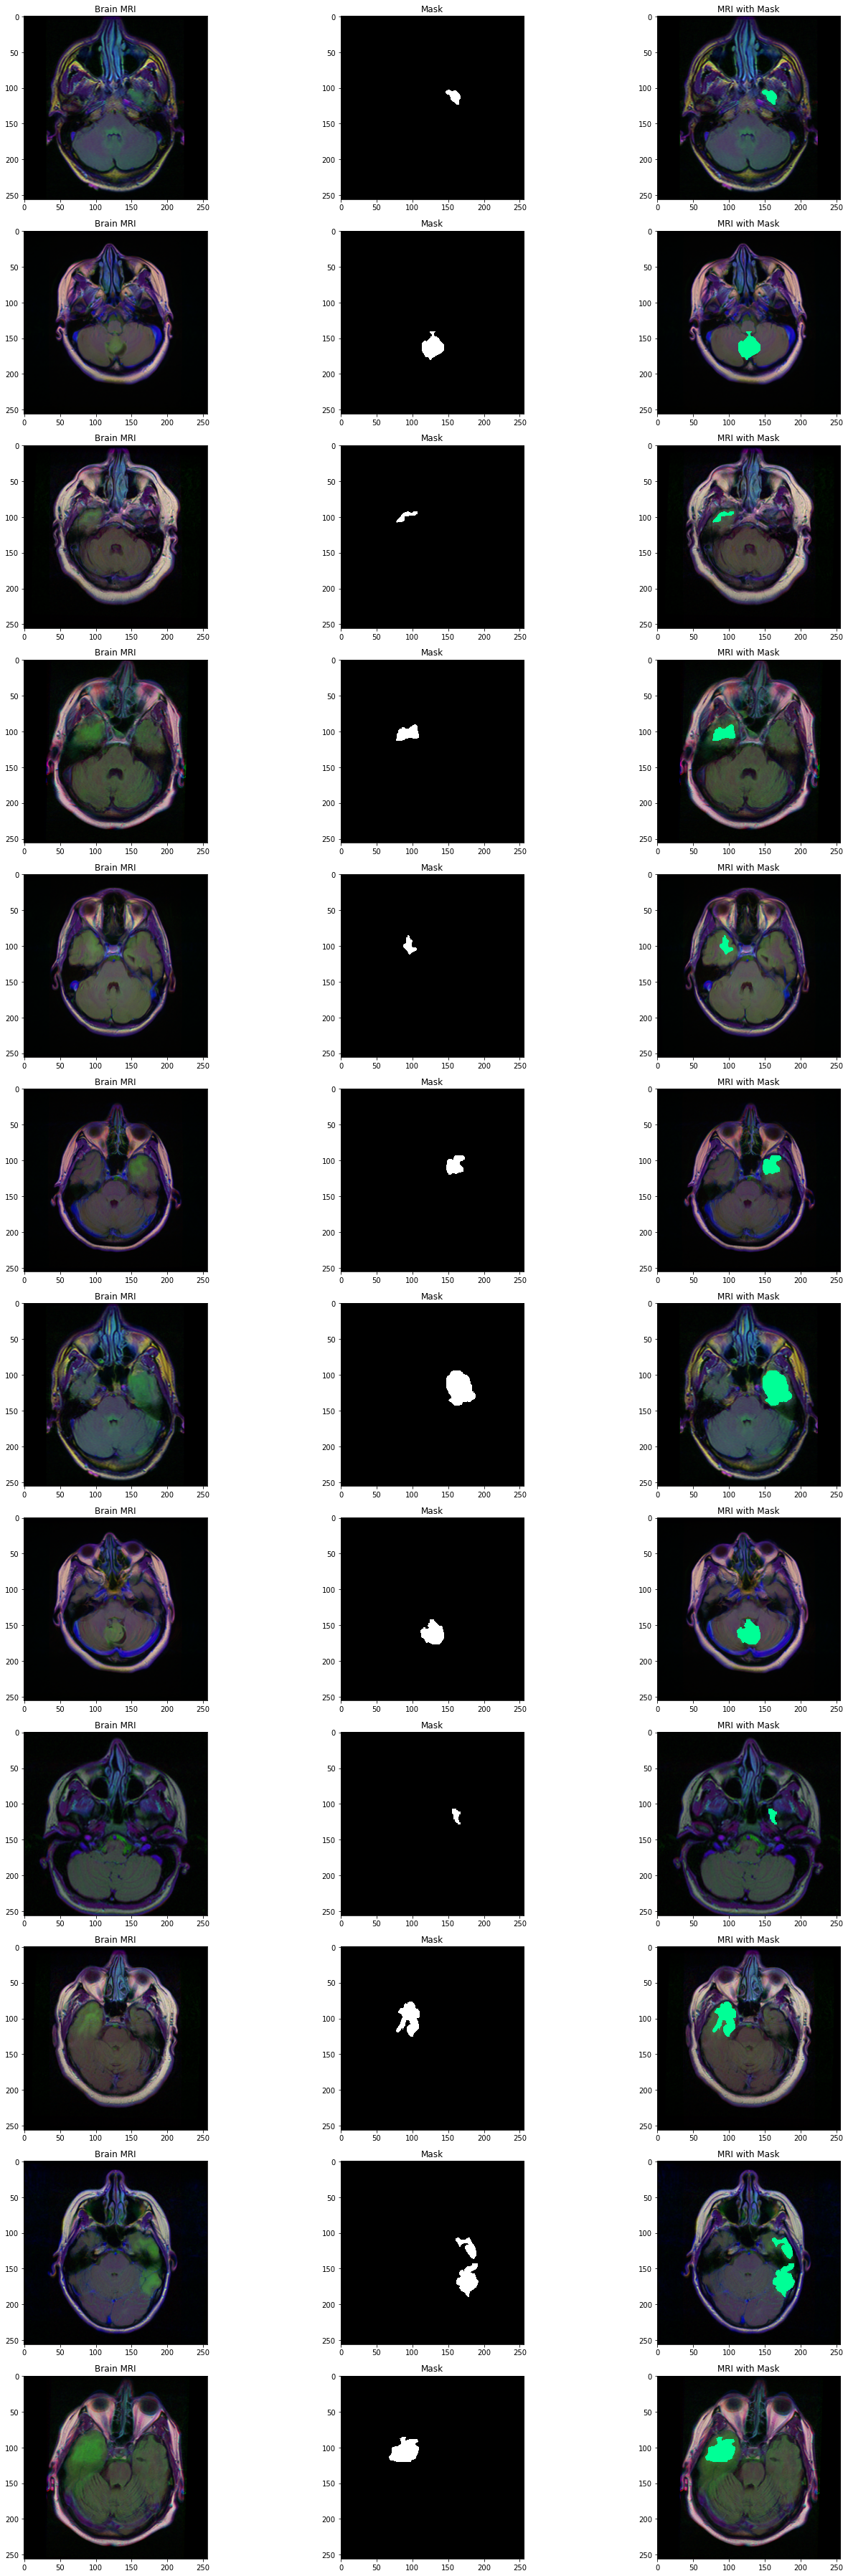

In [14]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# 5: CRETING TEST, TRAIN & VAL SET

In [15]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size=0.15, random_state = 123456)
fileNames = test["image_path"]
maskNames = test["mask_path"]
print(maskNames)

1661    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3673    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3656    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2102    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3283    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
                              ...                        
1614    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
3526    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2387    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
667     /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
2557    /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...
Name: mask_path, Length: 590, dtype: object


In [17]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

Found 3006 validated image filenames belonging to 2 classes.
Found 333 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


# 6: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT

In [18]:

"""import tensorflow.keras.applications as applications
from keras import applications
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

clf_model = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

#clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

#clf_model = VGG16(weights='imagenet', include_top=False)

clf_model.summary()
"""

"import tensorflow.keras.applications as applications\nfrom keras import applications\nfrom tensorflow.keras.applications.resnet50 import ResNet50\nfrom tensorflow.keras.applications import ResNet101\nfrom tensorflow.keras.applications import VGG16\n\nclf_model = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))\n\n#clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))\n\n#clf_model = VGG16(weights='imagenet', include_top=False)\n\nclf_model.summary()\n"

In [19]:
"""dir(applications)"""

'dir(applications)'

In [20]:
from tensorflow.keras.applications import ResNet101

In [21]:
"""# before this i tried with trainable layer but the accuracy was less as compared
for layer in clf_model.layers:
    layers.trainable = False
head = clf_model.output
head = AveragePooling2D(pool_size=(2,2))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 5, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

# saving model achitecture in json file
model_json = model.to_json()
with open("clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)"""

'# before this i tried with trainable layer but the accuracy was less as compared\nfor layer in clf_model.layers:\n    layers.trainable = False\nhead = clf_model.output\nhead = AveragePooling2D(pool_size=(2,2))(head)\nhead = Flatten(name=\'Flatten\')(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(256, activation=\'relu\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(2, activation=\'softmax\')(head)\nhead = Dropout(0.3)(head)\nhead = Dense(2, activation=\'softmax\')(head)\n\nmodel = Model(clf_model.input, head)\nmodel.compile(loss = \'categorical_crossentropy\', \n              optimizer=\'adam\', \n              metrics= ["accuracy"]\n             )\nmodel.summary()\n\nearlystopping = EarlyStopping(monitor=\'val_loss\', \n                              mode=\'min\', \n                              verbose=1, \n                              patience=15\n                             )\ncheckpointer = ModelCheckpoint(filepath="clf-resnet-weig

In [22]:
!ls
!pwd
!ls /kaggle/input/results
!if [ -d /kaggle/working/my_resnet101 ]; then echo "already exist"; else cp -ra /kaggle/input/results/. . ; fi


__notebook__.ipynb
/kaggle/working
ResUNet-seg-model.json	       clf-resnet101-weights.hdf5  my_resnet101.h5
ResUNet-segModel-weights.hdf5  clf-resnet50-model.json	   my_resnet50
__results___files	       clf-resnet50-weights.hdf5   my_resnet50.h5
clf-resnet101-model.json       my_resnet101


In [23]:
allPreds = []
all_models = []
dfPreds = pd.DataFrame()
import gc

In [24]:
"""loaded_model = tf.keras.models.load_model('my_resnet101')
prediction = loaded_model.predict(test_generator)
print(prediction)

del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)
dfPreds['my_resnet101'] = pred 
allPreds.append(pred)
all_models.append("my_resnet101")
# 7: CLASSIFIACTION MODEL EVALUATION"""

'loaded_model = tf.keras.models.load_model(\'my_resnet101\')\nprediction = loaded_model.predict(test_generator)\nprint(prediction)\n\ndel loaded_model\ngc.collect()\n\npred = np.argmax(prediction, axis=1)\ndfPreds[\'my_resnet101\'] = pred \nallPreds.append(pred)\nall_models.append("my_resnet101")\n# 7: CLASSIFIACTION MODEL EVALUATION'

In [25]:
"""loaded_model = tf.keras.models.load_model('/kaggle/input/resnet-no-1/resnet101')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()
pred = np.argmax(prediction, axis=1)

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

dfPreds['/kaggle/input/resnet-no-1/resnet101'] = pred 
allPreds.append(pred)
all_models.append("/kaggle/input/resnet-no-1/resnet101")

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1 
print("Number of false negatives in ResNet 101")
print(numFalseNegatives)

print("Number total wrong in ResNet 101")
print(numTotalWrong)
        

#--------------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/resnet-no-1/resnet50')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

print("pred, second time")
pred = np.argmax(prediction, axis=1)
print(pred)
allPreds.append(pred)
all_models.append('/kaggle/input/resnet-no-1/resnet50')
dfPreds['/kaggle/input/resnet-no-1/resnet50'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet 50")
print(numFalseNegatives)


print("Number total wrong in ResNet 50")
print(numTotalWrong)

#-----------------------------------------------------
loaded_model = tf.keras.models.load_model('/kaggle/input/resnet-no-1/resnet50_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/resnet-no-1/resnet50_2")
dfPreds['/kaggle/input/resnet-no-1/resnet50_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet 50 (2)")
print(numFalseNegatives)


print("Number total wrong in ResNet 50 (2)")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/resnet-no-1-e46ccc/MobileNet')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/resnet-no-1-e46ccc/MobileNet")
dfPreds['/kaggle/input/resnet-no-1-e46ccc/MobileNet'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet")
print(numFalseNegatives)


print("Number total wrong in MobileNet")
print(numTotalWrong)

#-------------------------------------------------
loaded_model = tf.keras.models.load_model('/kaggle/input/resnet-no-1-e46ccc/MobileNet-2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/resnet-no-1-e46ccc/MobileNet-2")
dfPreds['/kaggle/input/resnet-no-1-e46ccc/MobileNet-2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-2")
print(numFalseNegatives)


print("Number total wrong in MobileNet-2")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3")
dfPreds['/kaggle/input/fork-of-resnet-no-1-training-3/MobileNet-3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-3")
print(numFalseNegatives)


print("Number total wrong in MobileNet-3")
print(numTotalWrong)


#-------------------------------------------------
loaded_model = tf.keras.models.load_model('/kaggle/input/fork-of-resnet-no-1-training-3/MobileNetV2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/fork-of-resnet-no-1-training-3/MobileNetV2")
dfPreds['/kaggle/input/fork-of-resnet-no-1-training-3/MobileNetV2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNetV2")
print(numFalseNegatives)


print("Number total wrong in MobileNetV2")
print(numTotalWrong)


#-------------------------------------------------
loaded_model = tf.keras.models.load_model('/kaggle/input/fork-of-resnet-no-1-training-3/ResNet152')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/fork-of-resnet-no-1-training-3/ResNet152")
dfPreds['/kaggle/input/fork-of-resnet-no-1-training-3/ResNet152'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152")
print(numFalseNegatives)


print("Number total wrong in ResNet152")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/fork-of-resnet-no-1-training-3/resnet101_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/fork-of-resnet-no-1-training-3/resnet101_2")
dfPreds['/kaggle/input/fork-of-resnet-no-1-training-3/resnet101_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101_2")
print(numFalseNegatives)


print("Number total wrong in resnet101_2")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-01/MobileNet-2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-01/MobileNet-2")
dfPreds['/kaggle/input/training-all-01/MobileNet-2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-2")
print(numFalseNegatives)


print("Number total wrong in MobileNet-2")
print(numTotalWrong)

#-------------------------------------------------


loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-01/MobileNet-3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-01/MobileNet-3")
dfPreds['/kaggle/input/training-all-01/MobileNet-3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-3")
print(numFalseNegatives)


print("Number total wrong in MobileNet-3")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-01/MobileNet')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-01/MobileNet")
dfPreds['/kaggle/input/training-all-01/MobileNet'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet")
print(numFalseNegatives)


print("Number total wrong in MobileNet")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-01/ResNet152')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-01/ResNet152")
dfPreds['/kaggle/input/training-all-01/ResNet152'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152")
print(numFalseNegatives)


print("Number total wrong in ResNet152")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-01/ResNet152_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-01/ResNet152_2")
dfPreds['/kaggle/input/training-all-01/ResNet152_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152_2")
print(numFalseNegatives)


print("Number total wrong in ResNet152_2")
print(numFalseNegatives)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-00/resnet101')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-00/resnet101")
dfPreds['/kaggle/input/training-all-00/resnet101'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101")
print(numFalseNegatives)


print("Number total wrong in resnet101")
print(numTotalWrong)



#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-00/resnet101_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-00/resnet101_2")
dfPreds['/kaggle/input/training-all-00/resnet101_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101_2")
print(numFalseNegatives)


print("Number total wrong in resnet101_2")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-00/resnet50')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-00/resnet50")
dfPreds['/kaggle/input/training-all-00/resnet50'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50")
print(numFalseNegatives)


print("Number total wrong in resnet50")


print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-00/resnet50_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-00/resnet50_2")
dfPreds['/kaggle/input/training-all-00/resnet50_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50_2")
print(numFalseNegatives)


print("Number total wrong in resnet50_2")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-00/resnet50_3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-00/resnet50_3")
dfPreds['/kaggle/input/training-all-00/resnet50_3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50_3")
print(numFalseNegatives)


print("Number total wrong in resnet50_3")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-11-layers-trainable-true/MobileNet-2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-11-layers-trainable-true/MobileNet-2")
dfPreds['/kaggle/input/training-all-11-layers-trainable-true/MobileNet-2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-2")
print(numFalseNegatives)


print("Number total wrong in MobileNet-2")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-11-layers-trainable-true/MobileNet-3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-11-layers-trainable-true/MobileNet-3")
dfPreds['/kaggle/input/training-all-11-layers-trainable-true/MobileNet-3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-3")
print(numFalseNegatives)


print("Number total wrong in MobileNet-3")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-11-layers-trainable-true/MobileNet')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-11-layers-trainable-true/MobileNet")
dfPreds['/kaggle/input/training-all-11-layers-trainable-true/MobileNet'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet")
print(numFalseNegatives)


print("Number total wrong in MobileNet")
print(numTotalWrong)
#-------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-11-layers-trainable-true/ResNet152')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-11-layers-trainable-true/ResNet152")
dfPreds['/kaggle/input/training-all-11-layers-trainable-true/ResNet152'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152")
print(numFalseNegatives)


print("Number total wrong in ResNet152")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-11-layers-trainable-true/ResNet152_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-11-layers-trainable-true/ResNet152_2")
dfPreds['/kaggle/input/training-all-11-layers-trainable-true/ResNet152_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152_2")
print(numFalseNegatives)


print("Number total wrong in ResNet152_2")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-10-layers-trainable-true/resnet101')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-10-layers-trainable-true/resnet101")
dfPreds['/kaggle/input/training-all-10-layers-trainable-true/resnet101'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101")
print(numFalseNegatives)


print("Number total wrong in resnet101")
print(numTotalWrong)



#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-10-layers-trainable-true/resnet101_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-10-layers-trainable-true/resnet101_2")
dfPreds['/kaggle/input/training-all-10-layers-trainable-true/resnet101_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101_2")
print(numFalseNegatives)


print("Number total wrong in resnet101_2")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-10-layers-trainable-true/resnet50')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-10-layers-trainable-true/resnet50")
dfPreds['/kaggle/input/training-all-10-layers-trainable-true/resnet50'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50")
print(numFalseNegatives)


print("Number total wrong in resnet50")


print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-10-layers-trainable-true/resnet50_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-10-layers-trainable-true/resnet50_2")
dfPreds['/kaggle/input/training-all-10-layers-trainable-true/resnet50_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50_2")
print(numFalseNegatives)


print("Number total wrong in resnet50_2")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-10-layers-trainable-true/resnet50_3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-10-layers-trainable-true/resnet50_3")
dfPreds['/kaggle/input/training-all-10-layers-trainable-true/resnet50_3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50_3")
print(numFalseNegatives)


print("Number total wrong in resnet50_3")
print(numTotalWrong)


#------------------------------------------------- 


loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-20-metrics-falsenegatives/resnet101')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-20-metrics-falsenegatives/resnet101")
dfPreds['/kaggle/input/training-all-20-metrics-falsenegatives/resnet101'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101")
print(numFalseNegatives)


print("Number total wrong in resnet101")
print(numTotalWrong)



#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-20-metrics-falsenegatives/resnet101_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-20-metrics-falsenegatives/resnet101_2")
dfPreds['/kaggle/input/training-all-20-metrics-falsenegatives/resnet101_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet101_2")
print(numFalseNegatives)


print("Number total wrong in resnet101_2")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-20-metrics-falsenegatives/resnet50')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-20-metrics-falsenegatives/resnet50")
dfPreds['/kaggle/input/training-all-20-metrics-falsenegatives/resnet50'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50")
print(numFalseNegatives)


print("Number total wrong in resnet50")


print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_2")
dfPreds['/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50_2")
print(numFalseNegatives)


print("Number total wrong in resnet50_2")

print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_3")
dfPreds['/kaggle/input/training-all-20-metrics-falsenegatives/resnet50_3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in resnet50_3")
print(numFalseNegatives)


print("Number total wrong in resnet50_3")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-2")
dfPreds['/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-2")
print(numFalseNegatives)


print("Number total wrong in MobileNet-2")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-3')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-3")
dfPreds['/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet-3'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet-3")
print(numFalseNegatives)


print("Number total wrong in MobileNet-3")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet")
dfPreds['/kaggle/input/training-all-21-metrics-falsenegatives/MobileNet'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in MobileNet")
print(numFalseNegatives)


print("Number total wrong in MobileNet")
print(numTotalWrong)


#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152")
dfPreds['/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152")
print(numFalseNegatives)


print("Number total wrong in ResNet152")
print(numTotalWrong)

#-------------------------------------------------

loaded_model = tf.keras.models.load_model('/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152_2')
prediction = loaded_model.predict(test_generator)
del loaded_model
gc.collect()

pred = np.argmax(prediction, axis=1)

allPreds.append(pred)
all_models.append("/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152_2")
dfPreds['/kaggle/input/training-all-21-metrics-falsenegatives/ResNet152_2'] = pred 

#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')


numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(pred) - 1):
    if original[i] == 1 and pred[i] == 0:
        numFalseNegatives += 1
    if original[i] != pred[i]:
        numTotalWrong += 1
print("Number of false negatives in ResNet152_2")
print(numFalseNegatives)


print("Number total wrong in ResNet152_2")
print(numTotalWrong)


#-------------------------------------------------
"""

'loaded_model = tf.keras.models.load_model(\'/kaggle/input/resnet-no-1/resnet101\')\nprediction = loaded_model.predict(test_generator)\ndel loaded_model\ngc.collect()\npred = np.argmax(prediction, axis=1)\n\n#pred = np.asarray(pred).astype(\'str\')\noriginal = np.asarray(test[\'mask\']).astype(\'int\')\n\ndfPreds[\'/kaggle/input/resnet-no-1/resnet101\'] = pred \nallPreds.append(pred)\nall_models.append("/kaggle/input/resnet-no-1/resnet101")\n\nnumFalseNegatives = 0\nnumTotalWrong = 0\nfor i in range(len(pred) - 1):\n    if original[i] == 1 and pred[i] == 0:\n        numFalseNegatives += 1\n    if original[i] != pred[i]:\n        numTotalWrong += 1 \nprint("Number of false negatives in ResNet 101")\nprint(numFalseNegatives)\n\nprint("Number total wrong in ResNet 101")\nprint(numTotalWrong)\n        \n\n#--------------------------------------------------------\n\nloaded_model = tf.keras.models.load_model(\'/kaggle/input/resnet-no-1/resnet50\')\nprediction = loaded_model.predict(test_gene

In [26]:
"""
print("Im here")


print(allPreds)
print(all_models)
dfPreds
dfPreds.to_csv('export_dataframe.csv', index = False, header=True)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)
print("after accuracy")
cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
print(original)

finalResult = []

numSystems = 10
numSystemsTotal = len(allPreds)
print("numSystemTotal", numSystemsTotal)
import random
networksUsedInSystem = []

j = 0

while (j <= numSystems):
    newInt = random.randint(0, numSystemsTotal-1)
    if newInt not in networksUsedInSystem:
        networksUsedInSystem.append(newInt)
        j+= 1
    """

'\nprint("Im here")\n\n\nprint(allPreds)\nprint(all_models)\ndfPreds\ndfPreds.to_csv(\'export_dataframe.csv\', index = False, header=True)\n\nfrom sklearn.metrics import accuracy_score, confusion_matrix, classification_report\naccuracy = accuracy_score(original, pred)\nprint(accuracy)\nprint("after accuracy")\ncm = confusion_matrix(original, pred)\n\nreport = classification_report(original, pred, labels = [0,1])\nprint(report)\nplt.figure(figsize = (5,5))\nsns.heatmap(cm, annot=True);\nprint(original)\n\nfinalResult = []\n\nnumSystems = 10\nnumSystemsTotal = len(allPreds)\nprint("numSystemTotal", numSystemsTotal)\nimport random\nnetworksUsedInSystem = []\n\nj = 0\n\nwhile (j <= numSystems):\n    newInt = random.randint(0, numSystemsTotal-1)\n    if newInt not in networksUsedInSystem:\n        networksUsedInSystem.append(newInt)\n        j+= 1\n    '

In [27]:
finalResult = []
sumnet = 0
 
preds = pd.read_csv(
for i in range (len(pred)):
    sumnet = 0
    for k in networksUsedInSystem:
        print(allPreds[k][i])
        sumnet += allPreds[k][i]
    print("decision")
    if (sumnet >= 8.0):
        print("1")
        finalResult.append(1)
    else:
        print("0")
        finalResult.append(0)
        
"""
probabilityResult = []
for i in range (len(pred) - 1): 
    if (finalResult[0][i] + finalResult[1][i] + finalResult[2][i] + finalResult[3][i] + finalResult[4][i] >= 3.0): 
        probabilityResult.append(1)
    else:
        probabilityResult.append(0)
        
print("First System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[0][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[0][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
cm = confusion_matrix(original, allPreds[0])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

print("Second System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[1][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[1][i] == 1 and original[i] == 0):
        print("False positive ", i)

cm = confusion_matrix(original, allPreds[1])  
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

print("Third System, Errors")
for i in range(len(pred) - 1):
    if (allPreds[2][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[2][i] == 1 and original[i] == 0):
        print("False positive ", i)

cm = confusion_matrix(original, allPreds[2])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

print("Fourth System, Errors")
for i in range(len(pred) - 1):
    if (allPreds[3][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[3][i] == 1 and original[i] == 0):
        print("False positive ", i)

cm = confusion_matrix(original, allPreds[3])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

print("Fifth System, Errors")
for i in range(len(pred) - 1):
    if (allPreds[4][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[4][i] == 1 and original[i] == 0):
        print("False positive ", i)

cm = confusion_matrix(original, allPreds[4])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

print("Sixth System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[5][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[5][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
cm = confusion_matrix(original, allPreds[5])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

                 
print("Seventh System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[6][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[6][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
cm = confusion_matrix(original, allPreds[6])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
                 
    
print("Eighth System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[7][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[7][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
cm = confusion_matrix(original, allPreds[7])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);


print("Ninth System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[8][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[8][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
cm = confusion_matrix(original, allPreds[8])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);


print("Tenth System, Errors")

for i in range(len(pred) - 1):
    if (allPreds[9][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (allPreds[9][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
cm = confusion_matrix(original, allPreds[9])
report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
"""
print(finalResult)
print(original)
        
print("Wrong:")
numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(finalResult)):
    if original[i] == 1 and finalResult[i] == 0:
        numFalseNegatives += 1
        print("False Negative ", i)
    if original[i] != finalResult[i]:
        numTotalWrong += 1

print("Number of false negatives in entire system")
print(numFalseNegatives)


print("Number total wrong in entire system")
print(numTotalWrong)

print("Total system accuracy")
print(numTotalWrong/(len(pred) - 1))

      
    
"""
for i in range(294):
    if (probabilityResult[0][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (probabilityResult[0][i] == 1 and original[i] == 0):
        print("False positive ", i)
print("Second System, Errors")

for i in range(294):
    if (probabilityResult[1][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (probabilityResult[1][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
print("Third System, Errors")
for i in range(294):
    if (probabilityResult[2][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (probabilityResult[2][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
print("Fourth System, Errors")
for i in range(294):
    if (probabilityResult[3][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (probabilityResult[3][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
print("Fifth System, Errors")
for i in range(294):
    if (probabilityResult[4][i] == 0 and original[i] == 1):
        print("False negative ", i)
    elif (probabilityResult[4][i] == 1 and original[i] == 0):
        print("False positive ", i)
        
print(finalResult)
"""

SyntaxError: invalid syntax (<ipython-input-27-9a567c1e8e4e>, line 5)

In [28]:
"""finalResult = []
for i in range (len(pred)):
    if (allPreds[0][i] + allPreds[1][i] + allPreds[2][i] + allPreds[3][i] + allPreds[4][i] + allPreds[5][i] + allPreds[6][i] + allPreds[7][i] + allPreds[8][i] >= 1):
        finalResult.append(1)
    else:
        finalResult.append(0)"""

'finalResult = []\nfor i in range (len(pred)):\n    if (allPreds[0][i] + allPreds[1][i] + allPreds[2][i] + allPreds[3][i] + allPreds[4][i] + allPreds[5][i] + allPreds[6][i] + allPreds[7][i] + allPreds[8][i] >= 1):\n        finalResult.append(1)\n    else:\n        finalResult.append(0)'

In [29]:
"""print("fileNames")
print(fileNames)
print("original")
print(original)
print("finalResult")
print(finalResult)"""

'print("fileNames")\nprint(fileNames)\nprint("original")\nprint(original)\nprint("finalResult")\nprint(finalResult)'

In [30]:
filePathsWrong = []
maskPathsWrong = []
for i in range(len(pred)):
    if original[i] != finalResult[i]:
        numTotalWrong += 1
        condition = fileNames.iloc[i]
        mask = maskNames.iloc[i]
        print("Wrong", i, condition)
        if original[i] == 1 and finalResult[i] == 0:
            filePathsWrong.append(condition)
            maskPathsWrong.append(mask)
for i in range(len(filePathsWrong)): 
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.imshow(cv2.imread(filePathsWrong[i]));
    print(filePathsWrong[i])
    plt.title('File Path Wrong')

    plt.subplot(1,2,2)
    plt.imshow(cv2.imread(maskPathsWrong[i])); 
    print(maskPathsWrong[i])
    plt.title('Mask Path Wrong')

NameError: name 'pred' is not defined

In [31]:
print(pred)

print("Wrong:")
numFalseNegatives = 0
numTotalWrong = 0
for i in range(len(finalResult) - 1):
    if original[i] == 1 and finalResult[i] == 0:
        numFalseNegatives += 1
        print("False Negative ", i)
    if original[i] != finalResult[i]:
        numTotalWrong += 1
        print("Wrong ", i)
print("Number of false negatives in entire system")
print(numFalseNegatives)


print("Number total wrong in entire system")
print(numTotalWrong)

NameError: name 'pred' is not defined

In [32]:

numWrong = 0
numFalseNegatives = 0

for i in range(len(finalResult) - 1):
    if original[i] == 1 and finalResult[i] == 0:
        """print("FALSE NEGATIVE")
        print("Original", original[i])
        print("Final Result", finalResult [i])
        print("INCORRECT")
        print("Original", original[i])
        print("Final Result", finalResult [i])
        print(allPreds[0][i])
        print(allPreds[1][i])
        print(allPreds[2][i])
        print("system's decision: ", finalResult[i])
        print("correct answer: ", original[i])
        """
        print("False Negative: ", i)
        
        ####
        
        numWrong += 1
        numFalseNegatives += 1
    if original[i] == 0 and finalResult[i] == 1:     
        """print("INCORRECT")
        print("Original", original[i])
        print("Final Result", finalResult [i])
        print(allPreds[0][i])
        print(allPreds[1][i])
        print(allPreds[2][i])
        print("system's decision: ", finalResult[i])
        print("correct answer: ", original[i])
        """
       # print("False Positive: ", i)
        numWrong += 1 
        
print("Num false negatives:", numFalseNegatives)
print("Num wrong", numWrong)
  

NameError: name 'finalResult' is not defined

In [33]:
print(len(pred))

NameError: name 'pred' is not defined

# 7: CLASSIFIACTION MODEL EVALUATION

In [34]:
#h.history.keys()

In [35]:
"""plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);"""

'plt.figure(figsize=(12,5))\nplt.subplot(1,2,1)\nplt.plot(h.history[\'loss\']);\nplt.plot(h.history[\'val_loss\']);\nplt.title("Classification Model LOSS");\nplt.ylabel("loss");\nplt.xlabel("Epochs");\nplt.legend([\'train\', \'val\']);\n\nplt.subplot(1,2,2)\nplt.plot(h.history[\'accuracy\']);\nplt.plot(h.history[\'val_accuracy\']);\nplt.title("Classification Model Acc");\nplt.ylabel("Accuracy");\nplt.xlabel("Epochs");\nplt.legend([\'train\', \'val\']);'

In [36]:
"""_, acc = loaded_model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-36-0b26eabf1cda>, line 2)

In [37]:
"""prediction = loaded_model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['mask']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);
print(original)
print(pred)
"""
finalResult = [[]] 
for i in range (len(pred)-1):
    if pred[i] == 0: 
        finalResult[0].append(0)
    else:
        finalResult[0].append(1)
for j in range (len(pred)-1):
    if pred[i] == 0:
        finalResult[1].append(0)
    else:
        finalResult[1].append(1)
print(finalResult)


NameError: name 'pred' is not defined

In [38]:
for i in range(len(original)):
    if original[i] == 1 and pred[i] == 0:
        print("false negative", i)
    if original[i] == 0 and pred[i] == 1:
        print("false positive", i)
        

NameError: name 'original' is not defined

# 8: BUILDING A SEGMENTATION MODEL TO LOCALIZE TUMOR

In [39]:
""" 
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-39-ef98358dfd85>, line 3)

In [40]:
""" # creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-40-2309b6b58865>, line 10)

In [41]:
""" class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = str(list_ids[i])
      
      #mask path
      mask_path = str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-41-7cc73b99becb>, line 93)

![alt text](https://drive.google.com/uc?id=1WOmTUGT_3oN_ltzWlq9ofsw9E1eJwfwH)

![alt text](https://drive.google.com/uc?id=10XpINWmLDApPhIjxq_o8aTbeRjXIQRTD)

In [42]:
""" # lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input
    
    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    
    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)
    
    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-42-2f186fce5f78>, line 33)

In [43]:
""" input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
seg_model.summary()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-43-f58a9e597162>, line 46)

# 9: TRAINING SEGMENTATION MODEL

In [44]:
""" # Define a custom loss function for ResUNet model
'''
actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
'''
from keras.losses import binary_crossentropy

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-44-421f81c8f4ef>, line 28)

In [45]:
"""# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
seg_model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
#callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="ResUNet-segModel-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-45-0594f68272b0>, line 24)

In [46]:
""" h = seg_model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-46-0b88012fb48a>, line 5)

In [47]:
""" # saving model achitecture in json file
seg_model_json = seg_model.to_json()
with open("ResUNet-seg-model.json", "w") as json_file:
    json_file.write(seg_model_json)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-47-bd66baed6392>, line 4)

# 10: SEGMENTATION MODEL EVALUATION

In [48]:
"""h.history.keys()

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-48-004194117380>, line 1)

In [49]:
"""plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['tversky']);
plt.plot(h.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-49-c827e1b6c560>, line 16)

In [50]:
"""test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-50-ca7ad08051f0>, line 5)

# 11: SEGMENTATION MODEL PREFORMACE 
## (COMBINING CLASSIFICATION AND SEGMENTAION MODEL BUILDING PIPELINE)

In [51]:
"""def prediction(test, model, model_seg):
    '''
    Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
    Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
    is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
    segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
    '''
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,1
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-51-6a6ab3971c37>, line 62)

In [52]:
"""# making prediction
df_pred = prediction(test, model, seg_model)
df_pred

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-52-718bf20f3314>, line 3)

In [53]:
"""# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-53-3a90d3f217c5>, line 3)

In [54]:
"""#visualizing prediction
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask)
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()
        axs[count][2].imshow(pred)
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()        

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-54-726ff537e068>, line 39)